In [3]:
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from timeit import default_timer as timer
import pickle
from sklearn.preprocessing import LabelBinarizer

# needed for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
current_palette = sns.color_palette()

In [4]:
# Using TensorFlow V.12
tf.__version__

'0.12.0-rc1'

In [5]:
def getkey(item):
    fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds[item])
    roc_auc = auc(fpr, tpr)
    return roc_auc

def plotROC(testlabels, test_preds):
    classifiers = list(test_preds.keys())

    # Plot all ROC curves
    plt.figure(figsize=(15,9))
    for i, clf in zip(range(len(classifiers)), sorted(classifiers, key=getkey, reverse=True)):
        fpr, tpr, _ = roc_curve(testlabels.ravel(), test_preds[clf] )
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,
                 label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                       ''.format(roc_auc), linestyle='-', linewidth=2)


    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of multiclass ROC curves')
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

## Feature engineering. (not the best)
Using same dataset as const_MFCC, difference is feature engineering  
trying to manually take log of MFCC features.

In [6]:
data = pickle.load(open('const_shape.p', 'rb'))

In [24]:
data_cols = data.columns[:820]

# removing last two samples, because 8730 is much easier to iterate evenly in different sized chunks than 8732.
s = np.log(np.abs(data.loc[0:8729, data_cols]))
s['label'] = data['label']
print('working dataframe\'s shape:', s.shape)

working dataframe's shape: (8730, 821)


In [26]:
# test train split.
test_preds = {}
train = s[0:6984]
test = s[6984:]
LB = LabelBinarizer().fit(train['label'])
test_labels = LB.transform(test['label'])

# print shapes
print('train shape {}\ntest  shape {}\niterable chunks: 1, 2, 3, 6, 9, 18, 97, 194, 291, 582, 873, 1746'.format(train.shape, test.shape))

train shape (6984, 821)
test  shape (1746, 821)
iterable chunks: 1, 2, 3, 6, 9, 18, 97, 194, 291, 582, 873, 1746


In [8]:
del data

In [27]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def test_accuracy(session, test_data=test, during = True):
    test_data.reset_index(inplace=True, drop=True)
    epoch_pred = session.run(prediction, feed_dict={tf_data : np.array(test_data.loc[0:check_size-1,data_cols]).reshape(check_size,20,41), keep_prob : 1.0})
    for i in range(check_size, test_data.shape[0], check_size):
        epoch_pred = np.concatenate([epoch_pred, session.run(prediction, 
                                    feed_dict={tf_data : np.array(test_data.loc[i:i+check_size-1,data_cols]).reshape(check_size,20,41), keep_prob : 1.0})], axis=0)
    if during:
        return accuracy(epoch_pred, test_labels)
    else:
        return epoch_pred

## Run Session

In [28]:
num_labels = 10
batch_size = 97
acc_over_time = {}
def Run_Session(num_epochs, name, k_prob=1.0, mute=False, record=False):
    global train
    
    start = timer()
    with tf.Session(graph=graph) as session:
        if record:
            merged = tf.merge_all_summaries()  
            writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        #tf.initialize_all_variables().run()
        tf.global_variables_initializer().run()

        print("Initialized")
        accu = []
        
        for epoch in range(num_epochs):
            
            # get batch
            train_batch = train.sample(batch_size)
            
            t_d = np.asarray(train_batch[data_cols]).reshape(batch_size,20,41)
            t_l = LB.transform(train_batch['label'])
            
            # make feed dict
            feed_dict = { tf_data : t_d, train_labels : t_l, keep_prob : k_prob}
            
            # run model on batch
            _, l, predictions = session.run([optimizer, loss, prediction], feed_dict=feed_dict)
            
            # mid model accuracy checks 
            if (epoch % 1000 == 0) and not mute:
                print("\tMinibatch loss at epoch {}: {}".format(epoch, l))
                print("\tMinibatch accuracy: {:.1f}".format(accuracy(predictions, t_l)))
            if (epoch % 5000 == 0) and not mute:
                print("Test accuracy: {:.1f}".format(test_accuracy(session, during=True)))
            if (epoch % 1000 == 0) and not mute:
                accu.append(tuple([epoch, test_accuracy(session, during=True)]))
                
        # record accuracy and predictions
        test_preds[name] = test_accuracy(session, during=False)
        print("Final Test accuracy: {:.1f}".format(accuracy(test_preds[name], test_labels)))
        end = timer()
        test_preds[name] = test_preds[name].ravel()
        acc_over_time[name] = accu
        print("time taken: {0} minutes {1:.1f} seconds".format((end - start)//60, (end - start)%60))
        #tf.train.export_meta_graph()

## RNN

In [11]:
# constants
num_labels = 10
batch_size = 97
check_size = 97
rows, cols = 20, 41
n_hidden = 600
beta = 0.04

graph = tf.Graph()
with graph.as_default():
    # placeholders
    tf_data = tf.placeholder(tf.float32, shape=[None, rows, cols])
    train_labels = tf.placeholder(tf.float32, shape=[None, num_labels])
    keep_prob = tf.placeholder(tf.float32)
    
    # weights and biases
    layer1_weights = weight_variable([rows*n_hidden, num_labels])
    layer1_biases = bias_variable([num_labels])
    
    # model
    def model(data, proba=1.0):
        
        cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, state_is_tuple=True)
        #cell = tf.nn.rnn_cell.MultiRNNCell([ltsm] * 2, state_is_tuple=True)
        layer1, _istate = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)
        layer1 = tf.reshape(layer1, shape=[batch_size, rows*n_hidden])
        layer2 = tf.nn.dropout(layer1, proba)
        return tf.matmul(layer2, layer1_weights) + layer1_biases

    # Training computation.
    logits = model(tf_data, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, train_labels) +
                         beta*tf.nn.l2_loss(layer1_weights) +
                         beta*tf.nn.l2_loss(layer1_biases))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    # !!!! as this model does not allow calling model more than once we will need to get test predictions
    #      by running the test data through the same prediction op as the train data. !!!
    # !!! make note to not run optimizer on same function call !!!
    prediction = tf.nn.softmax(logits) 
    print('Basic RNN model made')

Basic RNN model made


In [12]:
Run_Session(20000, 'RNN', .2)

Initialized
	Minibatch loss at epoch 0: 2.567577600479126
	Minibatch accuracy: 15.5
Test accuracy: 11.6
	Minibatch loss at epoch 1000: 1.383567452430725
	Minibatch accuracy: 60.8
	Minibatch loss at epoch 2000: 0.6954327821731567
	Minibatch accuracy: 83.5
	Minibatch loss at epoch 3000: 0.48941051959991455
	Minibatch accuracy: 85.6
	Minibatch loss at epoch 4000: 0.14809764921665192
	Minibatch accuracy: 100.0
	Minibatch loss at epoch 5000: 0.15992623567581177
	Minibatch accuracy: 96.9
Test accuracy: 30.9
	Minibatch loss at epoch 6000: 0.11205485463142395
	Minibatch accuracy: 99.0
	Minibatch loss at epoch 7000: 0.15226969122886658
	Minibatch accuracy: 95.9
	Minibatch loss at epoch 8000: 0.09204017370939255
	Minibatch accuracy: 99.0
	Minibatch loss at epoch 9000: 0.10806972533464432
	Minibatch accuracy: 96.9
	Minibatch loss at epoch 10000: 0.07949729263782501
	Minibatch accuracy: 99.0
Test accuracy: 32.5
	Minibatch loss at epoch 11000: 0.05226586014032364
	Minibatch accuracy: 99.0
	Minibatc

## DeepNN

In [29]:
# constants
num_labels = 10

batch_size = 97
check_size = 582
rows, cols = 20, 41

n_hidden1 = 1200
n_hidden2 = 1500
n_hidden3 = 1200

beta = 0.01

graph = tf.Graph()
with graph.as_default():
    # placeholders
    tf_data = tf.placeholder(tf.float32, shape=[None, rows, cols])
    train_labels = tf.placeholder(tf.float32, shape=[None, num_labels])
    keep_prob = tf.placeholder(tf.float32)
    
    # weights and biases
    layer1_weights = weight_variable([rows*cols, n_hidden1])
    layer1_biases = bias_variable([n_hidden1])
    layer2_weights = weight_variable([n_hidden1, n_hidden2])
    layer2_biases = bias_variable([n_hidden2])
    layer3_weights = weight_variable([n_hidden2, n_hidden3])
    layer3_biases = bias_variable([n_hidden3])
    layer4_weights = weight_variable([n_hidden3, num_labels])
    layer4_biases = bias_variable([num_labels])

    # model
    def model(data, proba=1.0):
        
        layer1 = tf.nn.relu(tf.matmul(tf.reshape(data, [-1, rows*cols]), layer1_weights) + layer1_biases)
        layer1 = tf.nn.dropout(layer1, proba)
        
        layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weights) + layer2_biases)
        layer2 = tf.nn.dropout(layer2, proba)
        
        layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weights) + layer3_biases)
        layer3 = tf.nn.dropout(layer3, proba)
        
        return tf.matmul(layer3, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_data, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, train_labels) +
                         beta*tf.nn.l2_loss(layer1_weights) +
                         beta*tf.nn.l2_loss(layer1_biases) +
                         beta*tf.nn.l2_loss(layer2_weights) +
                         beta*tf.nn.l2_loss(layer2_biases) +
                         beta*tf.nn.l2_loss(layer3_weights) +
                         beta*tf.nn.l2_loss(layer3_biases) +
                         beta*tf.nn.l2_loss(layer4_weights) +
                         beta*tf.nn.l2_loss(layer4_biases))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    # !!!! as this RNN model does not allow calling model more than once we will need to get test predictions
    #      by running the test data through the same prediction op as the train data. !!!
    # !!! make note to not run optimizer on same function call !!!
    prediction = tf.nn.softmax(logits)  
    print('Basic DeepNN model made')

Basic DeepNN model made


In [31]:
Run_Session(10000, 'DeepNN', .5)

## CNN

In [15]:
# single layer CNN
num_labels = 10

batch_size = 97
check_size = 582
rows, cols = 20, 41
patch_size = 5
num_channels = 1
depth1 = 32

num_hidden = 2050

beta = 0.01

graph = tf.Graph()
with graph.as_default():
    
    tf_data = tf.placeholder(tf.float32, shape=(None, rows, cols))
    train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    #tf_test_dataset = tf.placeholder(tf.float32, shape=(check_size, image_size, image_size, num_channels))

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, 1, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([rows//2 * (cols//2 + 1) * depth1, num_hidden])
    layer2_biases = bias_variable([num_hidden])
    layer3_weights = weight_variable([num_hidden, num_labels])
    layer3_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1] , padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],strides=[1, 1, 1, 1], padding='SAME')

        # Fully Connected Layer
        shape = pooled1.get_shape().as_list()
        reshape = tf.reshape(pooled1, [-1, shape[1] * shape[2] * shape[3]])
        full2 = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)

        # Dropout
        full2 = tf.nn.dropout(full2, proba)
        
        return tf.matmul(full2, layer3_weights) + layer3_biases

    # Training computation.
    logits = model(tf.expand_dims(tf_data, -1), keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, train_labels) +
                         beta*tf.nn.l2_loss(layer1_weights) +
                         beta*tf.nn.l2_loss(layer1_biases) +
                         beta*tf.nn.l2_loss(layer2_weights) +
                         beta*tf.nn.l2_loss(layer2_biases) +
                         beta*tf.nn.l2_loss(layer3_weights) +
                         beta*tf.nn.l2_loss(layer3_biases))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    prediction = tf.nn.softmax(logits)
    #test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))  
    print('Basic CNN model made')

Basic CNN model made


In [16]:
Run_Session(20000, 'CNN', .5)

Initialized
	Minibatch loss at epoch 0: 7.75794792175293
	Minibatch accuracy: 6.2
Test accuracy: 12.4
	Minibatch loss at epoch 1000: 1.982966423034668
	Minibatch accuracy: 35.1
	Minibatch loss at epoch 2000: 1.7484956979751587
	Minibatch accuracy: 44.3
	Minibatch loss at epoch 3000: 1.5821635723114014
	Minibatch accuracy: 54.6
	Minibatch loss at epoch 4000: 1.4924242496490479
	Minibatch accuracy: 57.7
	Minibatch loss at epoch 5000: 1.5107589960098267
	Minibatch accuracy: 58.8
Test accuracy: 37.2
	Minibatch loss at epoch 6000: 1.1542561054229736
	Minibatch accuracy: 77.3
	Minibatch loss at epoch 7000: 1.1912972927093506
	Minibatch accuracy: 77.3
	Minibatch loss at epoch 8000: 1.0234284400939941
	Minibatch accuracy: 81.4
	Minibatch loss at epoch 9000: 1.0523602962493896
	Minibatch accuracy: 83.5
	Minibatch loss at epoch 10000: 0.9625751972198486
	Minibatch accuracy: 89.7
Test accuracy: 40.0
	Minibatch loss at epoch 11000: 0.954519510269165
	Minibatch accuracy: 85.6
	Minibatch loss at epo

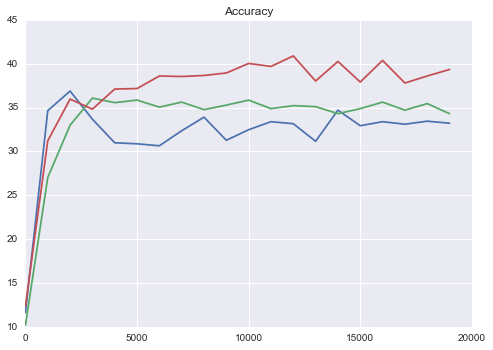

In [17]:
plt.plot(np.array(acc_over_time['RNN'])[:,0], np.array(acc_over_time['RNN'])[:,1])
plt.plot(np.array(acc_over_time['DeepNN'])[:,0], np.array(acc_over_time['DeepNN'])[:,1])
plt.plot(np.array(acc_over_time['CNN'])[:,0], np.array(acc_over_time['CNN'])[:,1])
plt.title('Accuracy')
plt.show()

In [27]:
# record measurements
#dataset_acc = pickle.load(open('dataset_acc.p','rb'))
dataset_acc['const_LogMFCC'] = {'DeepNN':np.array(acc_over_time['DeepNN'])[-1,1],
                              'RNN': np.array(acc_over_time['RNN'])[-1,1],
                              'CNN': np.array(acc_over_time['CNN'])[-1,1]}
#pickle.dump(dataset_acc, open('dataset_acc.p','wb'))

In [26]:
dataset_acc

{'const_LogMFCC': {'CNN': 39.34707903780069,
  'DeepNN': 34.306987399770904,
  'RNN': 33.218785796105387},
 'features193': {'CNN': 65.4639175257732,
  'DeepNN': 63.57388316151203,
  'RNN': 60.53837342497136}}

In [ ]:
plotROC(test_labels, test_preds)